In [22]:
from collections import OrderedDict

import numpy as np
from scipy.stats import multivariate_normal

import pickle

import matplotlib.pyplot as plt

import gen_metrics
import dists

from math import ceil, sqrt

import pandas as pd

from IPython.display import Markdown, display

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/Sep11"
_ = os.system(f"mkdir -p {plot_dir}")


In [32]:
num_batches = 10
tot_num_samples = 10_000

batch_sizes = {
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "mmdub": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdu": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdl": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "dc": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
}


In [5]:
metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        # ("mmdub", (gen_metrics.mmd_gaussian_quadratic_biased, {}, "MMD Quadratic Biased Est.")),
        ("mmdu", (gen_metrics.mmd_gaussian_quadratic_unbiased, {}, "MMD Quadratic Unbiased Est.")),
        ("mmdl", (gen_metrics.mmd_gaussian_linear, {}, "MMD Linear Estimator")),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
        ("dc", (gen_metrics.dc, {}, ["Density", "Coverage"])),
    ]
)


In [6]:
true_var = 1.0
true_cov = 0.25
var_factor = 10

test_dists = [
    (
        rf"Truth N(0.0 $\mu$, {true_var} $\sigma^2$, {true_cov} cov)",
        multivariate_normal([0, 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"$\mu_x$ += {sqrt(true_var)}",
        multivariate_normal([sqrt(true_var), 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"$\mu_x$ += {sqrt(true_var) / 10.}",
        multivariate_normal(
            [sqrt(true_var) / 10.0, 0], [[true_var, true_cov], [true_cov, true_var]]
        ),
    ),
    (
        rf"0 cov",
        multivariate_normal(
            [0, 0], [[true_var, 0], [0, true_var]]
        ),
    ),
    (
        rf"$\sigma^2$ x= {var_factor}",
        multivariate_normal(
            [0, 0],
            [
                [true_var * var_factor, true_cov * var_factor],
                [true_cov * var_factor, true_var * var_factor],
            ],
        ),
    ),
    (
        rf"$\sigma^2$ /= {var_factor}",
        multivariate_normal(
            [0, 0],
            [
                [true_var / var_factor, true_cov / var_factor],
                [true_cov / var_factor, true_var / var_factor],
            ],
        ),
    ),
    (r"Mixture of Two Gaussians", dists.two_multivariate_normals(sqrt(true_cov), true_var - true_cov)),
]

# kernel_var = gen_metrics.get_kernel_var(true_samples)
# metrics["mmdub"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdu"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdl"][1]["kernel_sigma"] = sqrt(true_var)


# Plot distributions

In [7]:
bound = 3
x, y = np.mgrid[-bound:bound:0.01, -bound:bound:0.01]
pos = np.dstack((x, y))

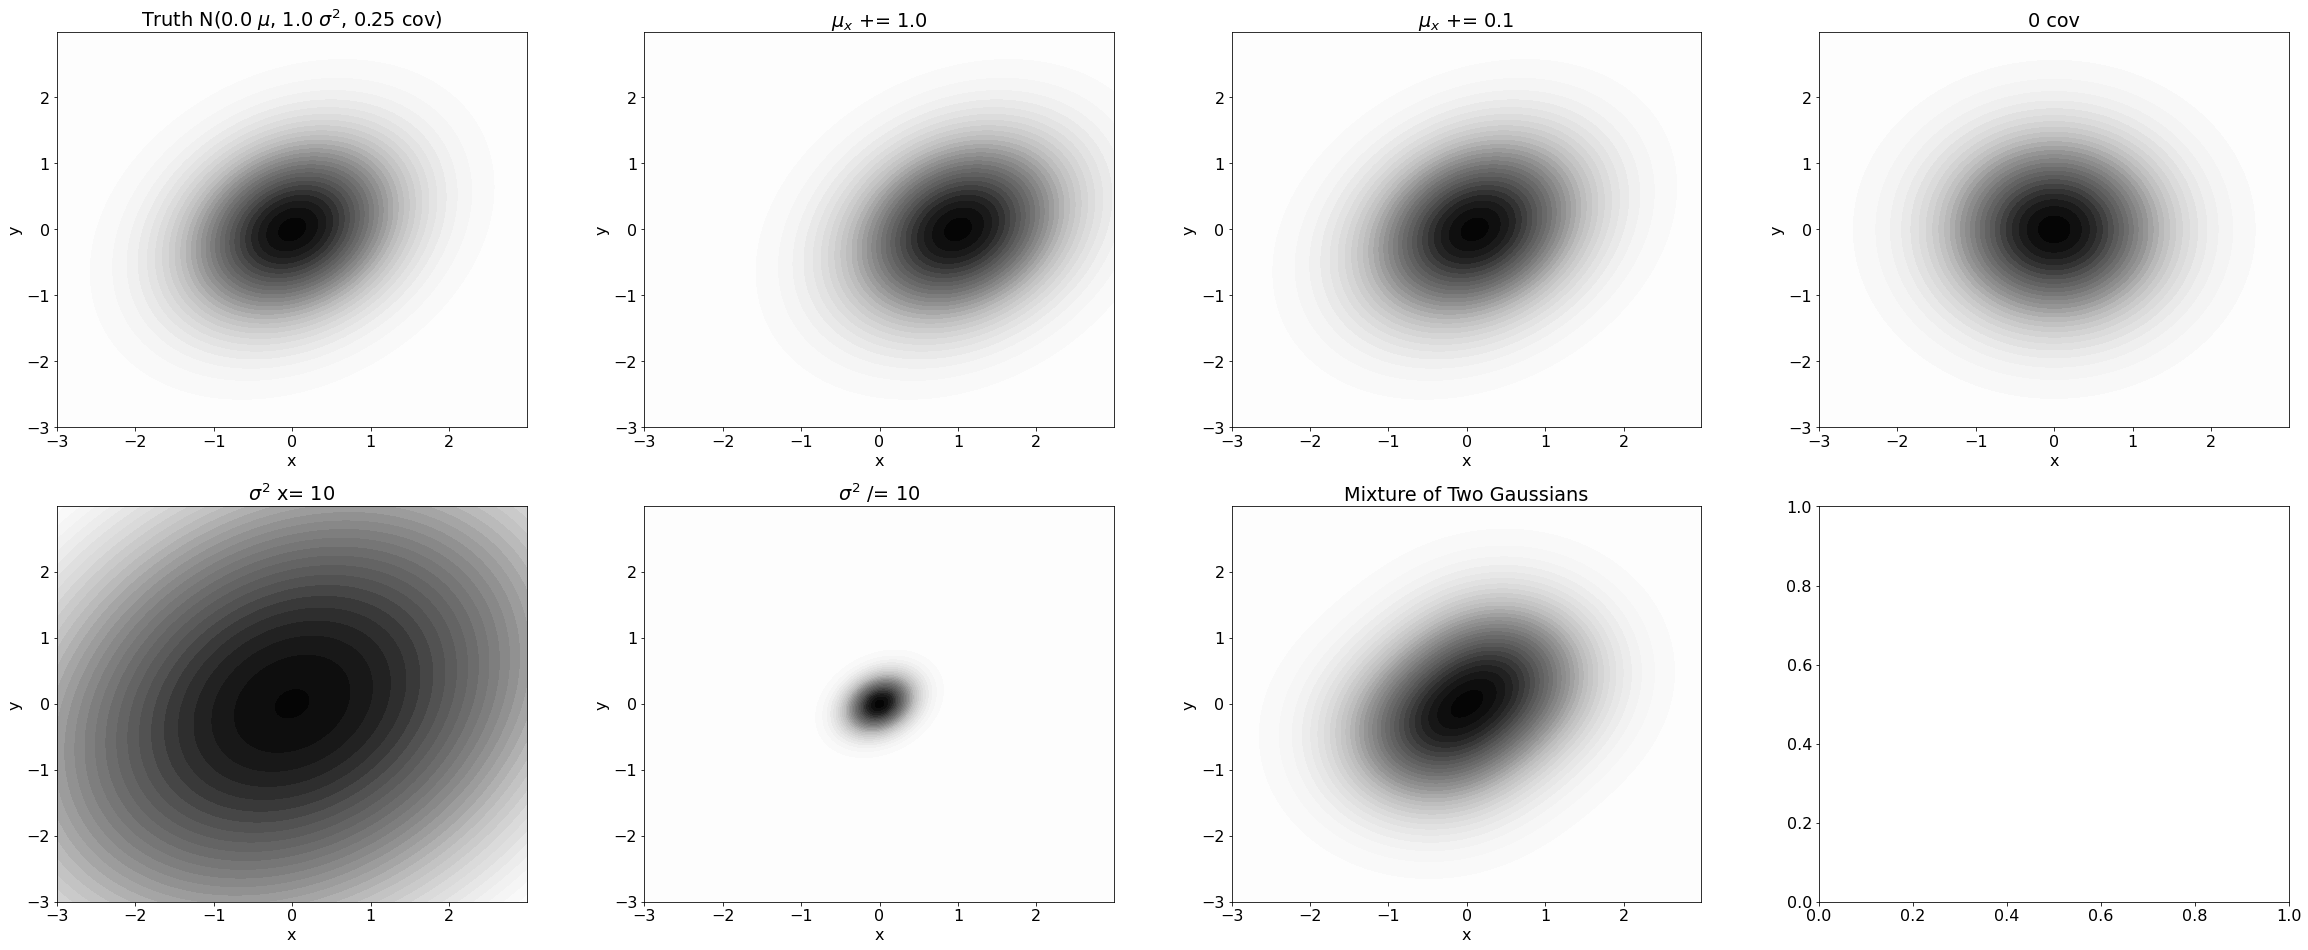

In [16]:
cm = plt.cm.Greys

nrows = 2
ncols = int(ceil(len(test_dists) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)


for i, (label, dist) in enumerate(test_dists):
    row = i // ncols
    col = i % ncols
    axes[row][col].contourf(x, y, dist.pdf(pos), 30, cmap=cm)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("x")
    axes[row][col].set_ylabel("y")

plt.savefig(f"{plot_dir}/test_dists.pdf", bbox_inches="tight")


# Measure metrics

In [9]:
samples = OrderedDict()

true_samples = test_dists[0][1].rvs(tot_num_samples)

for key, dist in test_dists:
    samples[key] = dist.rvs(tot_num_samples)

In [10]:
metrics["pr"][1]["X_nearest_neighbour_distances"] = {}
metrics["dc"][1]["X_nearest_neighbour_distances"] = {}

for batch_size in batch_sizes["pr"]:
    xnnd = gen_metrics.compute_nearest_neighbour_distances(true_samples[:batch_size])
    metrics["pr"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd
    metrics["dc"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd


In [33]:
if 'measurements' not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()
    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements[dkey] and mkey != "wasserstein":
            continue
        
        print(mkey)
        ms = []
        ts = []
        for batch_size in batch_sizes[mkey]:
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                    true_samples, samples[dkey], num_batches, batch_size, metric, timing=True, **metric_args
                )
            ms.append(mean_std)
            ts.append(timing)
        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration

$\mu_x$ += 1.0
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

$\mu_x$ += 0.1
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

0 cov
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

$\sigma^2$ x= 10
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

$\sigma^2$ /= 10
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

Mixture of Two Gaussians
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is v

In [38]:
with open(f"{plot_dir}/measurements.pkl", "wb") as f:
    pickle.dump(measurements, f)

# Plot Metrics

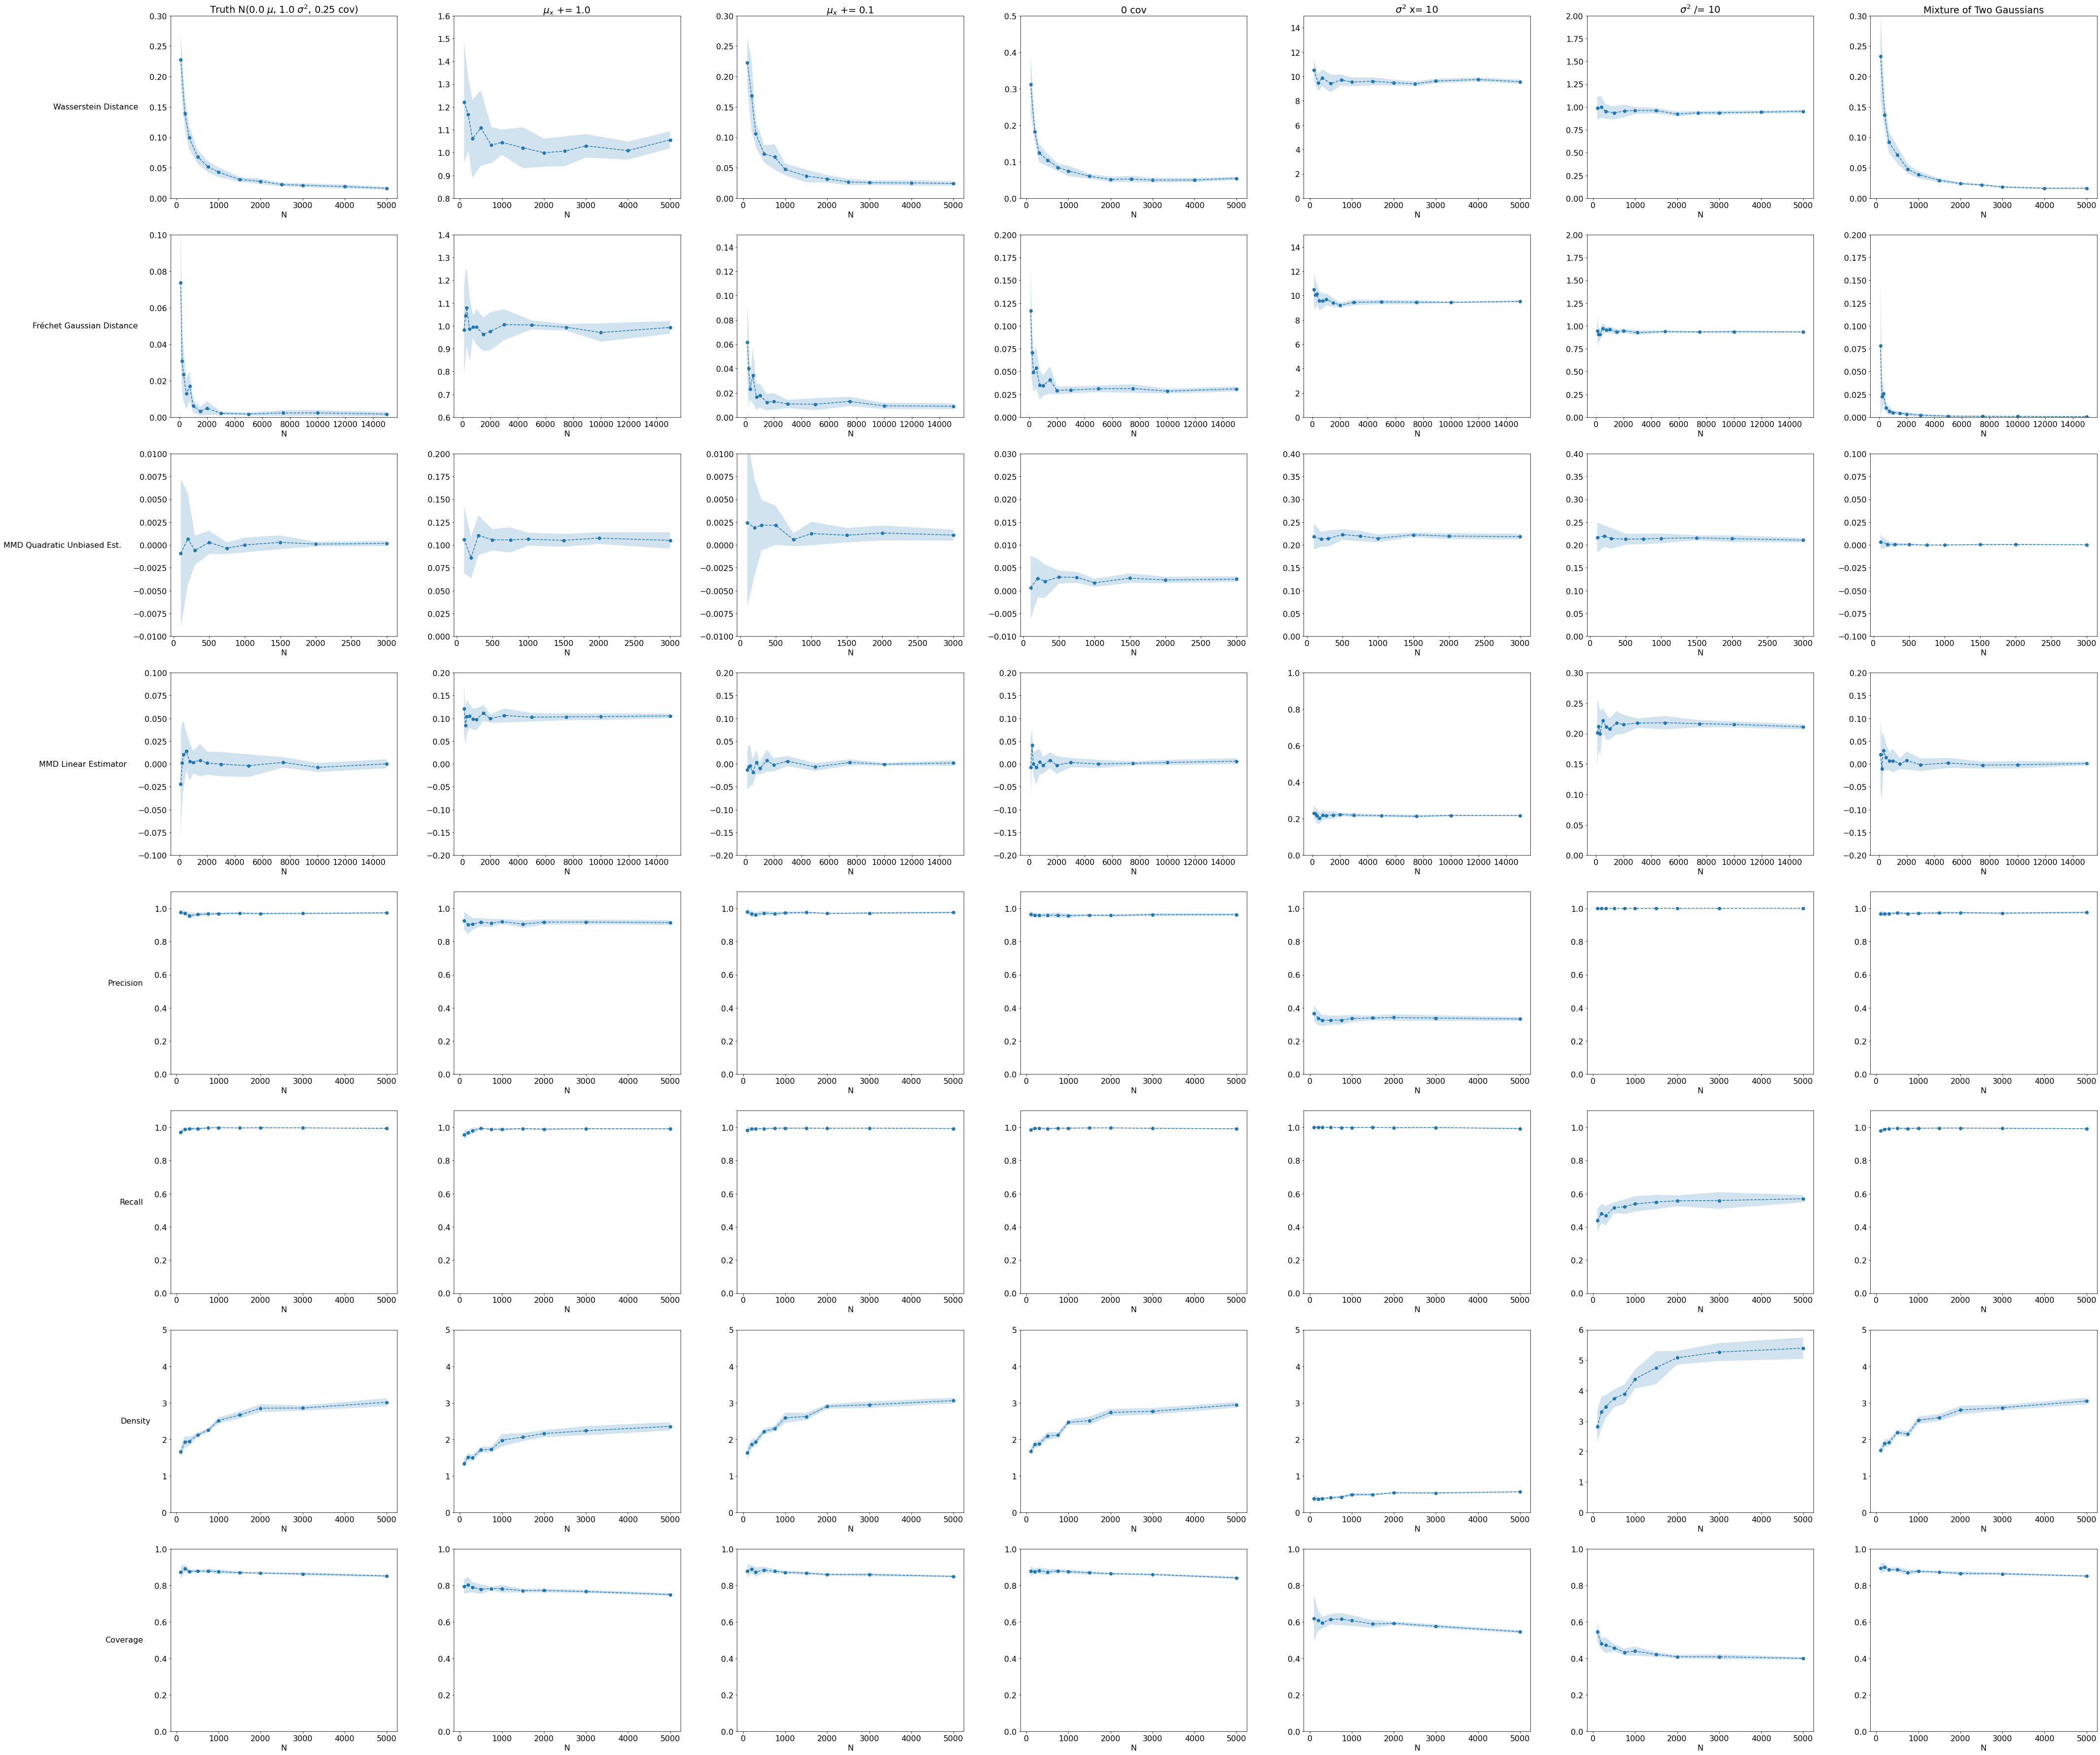

In [35]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 0.3], [0.8, 1.6], [0, 0.3], [0, 0.5], [0, 15], [0, 2], [0, 0.3])),
        ("fgd", ([0, 0.1], [0.6, 1.4], [0, 0.15], [0, 0.2], [0, 15], [0, 2], [0, 0.2])),
        # ("mmdub", ([0, 0.02], [0, 0.2], [0, 0.02], [0, 1], [0, 0.2], [-0.1, 0.1])),
        ("mmdu", ([-0.01, 0.01], [0, 0.2], [-0.01, 0.01], [-0.01, 0.03], [0, 0.4], [0, 0.4], [-0.1, 0.1])),
        ("mmdl", ([-0.1, 0.1], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [0, 1], [0, 0.3], [-0.2, 0.2])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("density", ([0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5])),
        ("coverage", ([0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(test_dists),
    figsize=(len(test_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0])
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 4 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


for k, key in enumerate(["density", "coverage"]):
    i = len(ylims) - 2 + k
    mkey = "dc"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/scores.pdf", bbox_inches="tight")


# Table of values

In [18]:
def disp_df(df):
    display(Markdown(df.to_markdown()))

In [36]:
rows = []

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l]

            for dkey, values in measurements.items():
                row.append(
                    f"{values[mkey]['mean_std'][-1][0][i]:.2f} ± {values[mkey]['mean_std'][-1][1][i]:.2f}"
                )

            rows.append(row)

    else:
        row = [label]

        for dkey, values in measurements.items():
            row.append(
                f"{values[mkey]['mean_std'][-1][0]:.2f} ± {values[mkey]['mean_std'][-1][1]:.2f}"
            )

        rows.append(row)

results = pd.DataFrame(rows, columns=["Metric"] + list(measurements.keys()))

display(Markdown(results.to_markdown()))


|    | Metric                      | Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)   | $\mu_x$ += 1.0   | $\mu_x$ += 0.1   | 0 cov       | $\sigma^2$ x= 10   | $\sigma^2$ /= 10   | Mixture of Two Gaussians   |
|---:|:----------------------------|:-----------------------------------------------|:-----------------|:-----------------|:------------|:-------------------|:-------------------|:---------------------------|
|  0 | Wasserstein Distance        | 0.02 ± 0.00                                    | 1.06 ± 0.04      | 0.02 ± 0.00      | 0.05 ± 0.00 | 9.57 ± 0.17        | 0.95 ± 0.02        | 0.02 ± 0.00                |
|  1 | Fréchet Gaussian Distance   | 0.00 ± 0.00                                    | 0.99 ± 0.03      | 0.01 ± 0.00      | 0.03 ± 0.00 | 9.52 ± 0.08        | 0.93 ± 0.01        | 0.00 ± 0.00                |
|  2 | MMD Quadratic Unbiased Est. | 0.00 ± 0.00                                    | 0.10 ± 0.01      | 0.00 ± 0.00      | 0.00 ± 0.00 | 0.22 ± 0.01        | 0.21 ± 0.00        | 0.00 ± 0.00                |
|  3 | MMD Linear Estimator        | 0.00 ± 0.00                                    | 0.11 ± 0.01      | 0.00 ± 0.01      | 0.01 ± 0.01 | 0.22 ± 0.00        | 0.21 ± 0.00        | 0.00 ± 0.00                |
|  4 | Precision                   | 0.97 ± 0.01                                    | 0.91 ± 0.01      | 0.97 ± 0.01      | 0.96 ± 0.01 | 0.33 ± 0.01        | 1.00 ± 0.00        | 0.97 ± 0.01                |
|  5 | Recall                      | 0.99 ± 0.00                                    | 0.99 ± 0.00      | 0.99 ± 0.00      | 0.99 ± 0.00 | 0.99 ± 0.00        | 0.57 ± 0.02        | 0.99 ± 0.00                |
|  6 | Density                     | 3.01 ± 0.11                                    | 2.35 ± 0.11      | 3.06 ± 0.08      | 2.94 ± 0.08 | 0.56 ± 0.01        | 5.39 ± 0.35        | 3.05 ± 0.09                |
|  7 | Coverage                    | 0.85 ± 0.01                                    | 0.75 ± 0.01      | 0.85 ± 0.00      | 0.84 ± 0.01 | 0.55 ± 0.01        | 0.40 ± 0.01        | 0.85 ± 0.00                |

In [37]:
results.to_csv(f"{plot_dir}/scores.csv")

# Plot Timings

In [48]:
timings = OrderedDict()

for mkey in metrics:
    mtimings = []
    for i, batch_size in enumerate(batch_sizes[mkey]):
        mbtimings = []
        for values in measurements.values():
            mbtimings.append(values[mkey]['timing'][i])
        
        mtimings.append([np.mean(mbtimings), np.std(mbtimings)])

    timings[mkey] = np.array(mtimings)


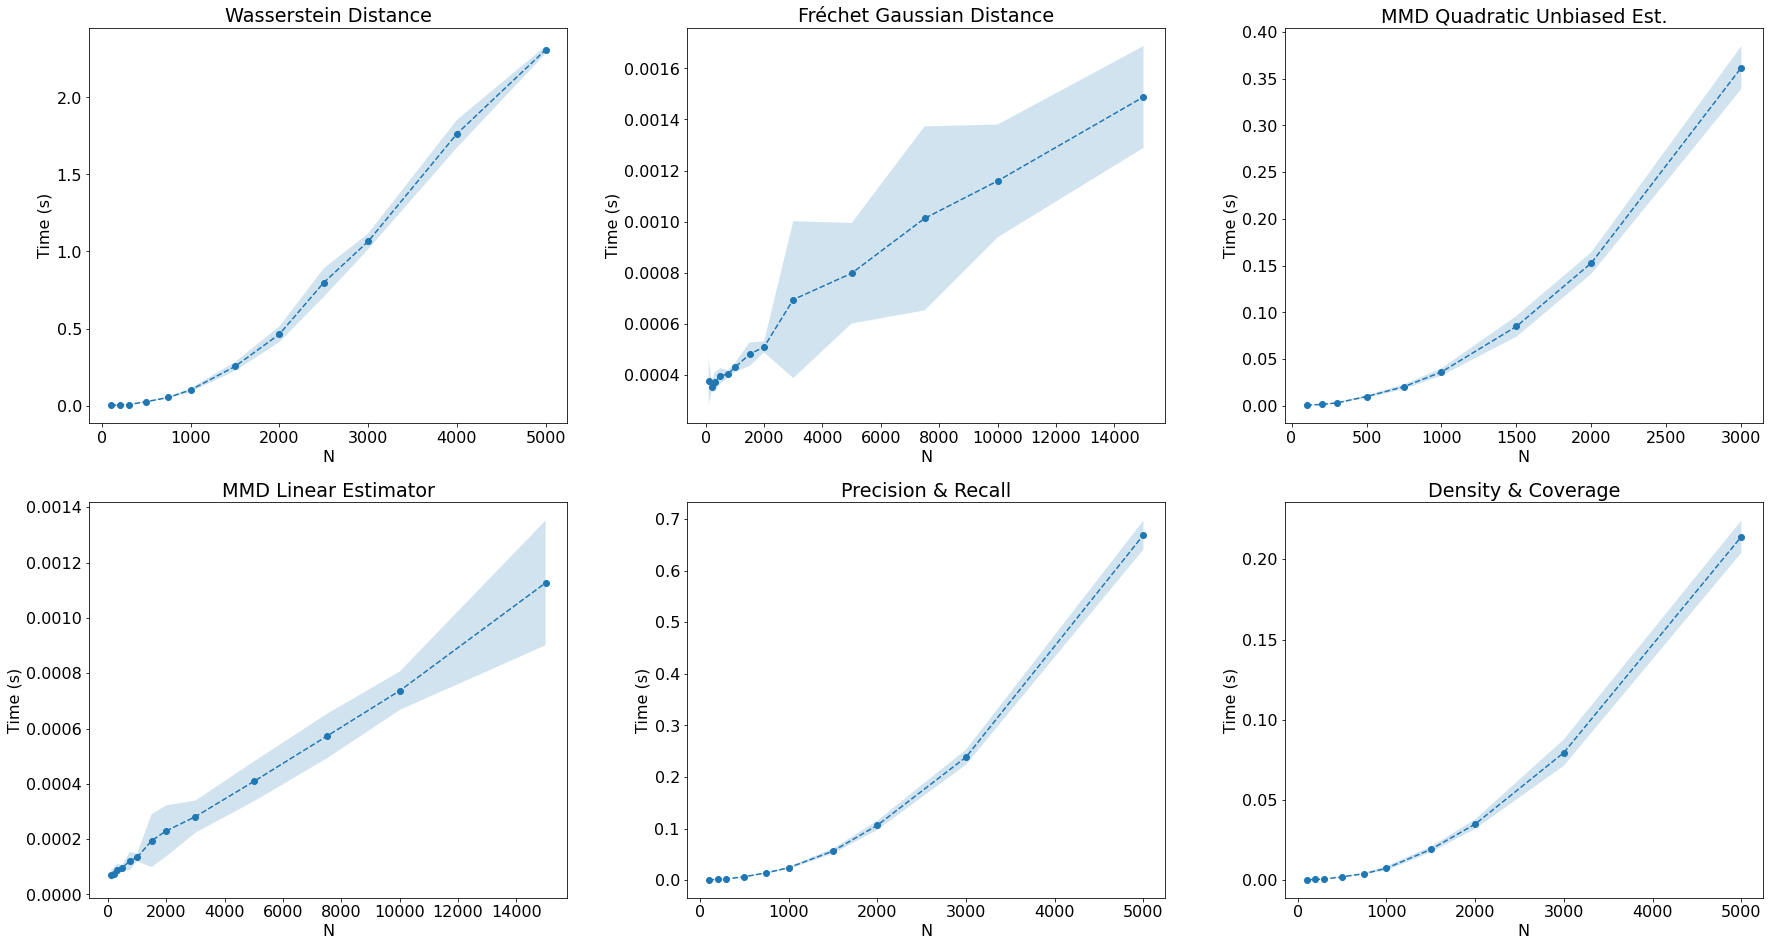

In [50]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 0.3], [0.8, 1.6], [0, 0.3], [0, 0.5], [0, 15], [0, 2], [0, 0.5])),
        ("fgd", ([0, 0.1], [0.6, 1.4], [0, 0.15], [0, 0.2], [0, 15], [0, 2], [0, 0.2])),
        # ("mmdub", ([0, 0.02], [0, 0.2], [0, 0.02], [0, 1], [0, 0.2], [-0.1, 0.1])),
        ("mmdu", ([-0.01, 0.01], [0, 0.2], [-0.01, 0.01], [-0.01, 0.03], [0, 0.4], [0, 0.4], [-0.1, 0.1])),
        ("mmdl", ([-0.1, 0.1], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [0, 1], [0, 0.3], [-0.2, 0.2])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("density", ([0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5])),
        ("coverage", ([0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1])),
    ]
)

nrows = 2
ncols = int(ceil(len(metrics) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    row = i // ncols
    col = i % ncols

    if isinstance(label, list):
        label = " & ".join(label)

    means = timings[mkey][:, 0]
    stds = timings[mkey][:, 1]

    axes[row][col].plot(
        batch_sizes[mkey],
        means,
        marker="o",
        linestyle="--",
    )

    axes[row][col].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("N")
    axes[row][col].set_ylabel("Time (s)")

plt.savefig(f"{plot_dir}/timings.pdf", bbox_inches="tight")